In [1]:
%matplotlib inline

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Introduction to Computer Vision - Sections 1 - 2

These two sections mainly introduced some basic ideas and tools required for computer vision.  Topics covered included images as functions, filter, linearity, convolution, edge detection, Hough transforms, and Fourier Transforms.  Below I am going to work through a few examples to help improve my understanding.  Mostly I am going to use the Scikits Image library, but where I can I'll write my own code. 

## Filtering
The general idea behind filtering of images is to reduce the noise in the image, or enhance some of the features.  

#### Load an image and convert to greyscale

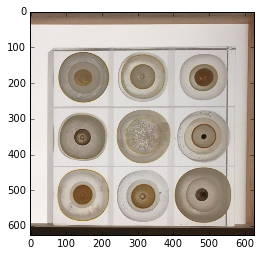

In [12]:
from skimage import io
filename = os.path.join('../images', 'image_circles.png')
img_in = io.imread(filename)
plt.imshow(img_in)

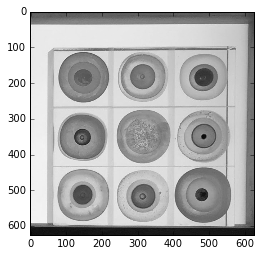

In [15]:
from skimage.color import rgb2gray
img_in_grey = rgb2gray(img_in)
plt.imshow(img_in_grey, cmap='gray')

While there are functions in Scikits-Image to produce a gaussian filter, its fairly straight foward to create one:

In [51]:
def gauss_filter(length = 10, sigma = 1):
    '''Creates a 2D gaussian filter of shape (length + 1, length + 1) with a standard deviation
        of sigma.
    '''
    half_side = length//2
    ax = np.arange(-half_side, half_side + 1)
    
    X, Y = np.meshgrid(ax, ax)  
    gauss_filt = np.exp(-(X**2 + Y**2) / (2. * sigma**2) )
    
    return gauss_filt/np.sum(gauss_filt), half_side

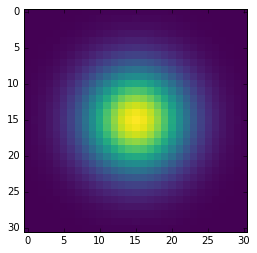

In [92]:
filt, hs = gauss_filter(length = 31, sigma = 5)
plt.imshow(filt, interpolation='nearest', cmap='viridis')

We can then apply this filter to the image (in a non comptationally effiecient way and just ignoring the edges)

In [62]:
img_out = img_in_grey.copy()
x, y = img_in_grey.shape

for x_i in range(hs, x-hs):
    for y_i in range(hs, y-hs):
        img_out[x_i, y_i] = np.sum(filt * img_in_grey[x_i-hs:x_i+hs+1, y_i-hs:y_i+hs+1]) 
        

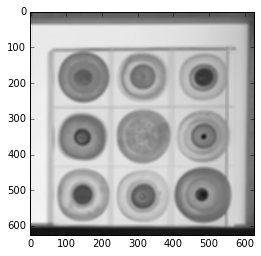

In [63]:
plt.imshow(img_out, cmap='gray')

Looks pretty much like what we would expect.  Looking at a line segment can show the effect of the smoothing.

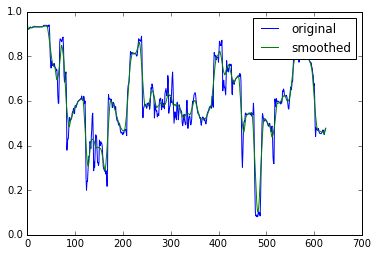

In [68]:
fig, ax  = plt.subplots(1, 1)
ax.plot(img_in_grey[350,:], label='original')
ax.plot(img_out[350,:], label='smoothed')
ax.legend()

As we expect, the higher frequency oscillations have been smoothed out.  

Filters can also be used for template matching.  If we have a template of a feature we are looking for, we can apply this to the image, and by using the correlation we can find where the template matches best.

Extract a template:

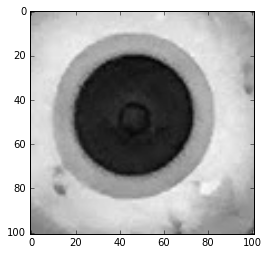

In [77]:
template = img_in_grey[465:566, 100:201]
plt.imshow(template, cmap='gray')

Apply the template matching (not algortihmically efficient)

In [81]:
img_out = np.zeros(img_in_grey.shape)
x, y = img_in_grey.shape
hs = 50
for x_i in range(hs, x-hs):
    for y_i in range(hs, y-hs):
        img_out[x_i, y_i] = np.corrcoef(template.ravel(), img_in_grey[x_i-hs:x_i+hs+1, y_i-hs:y_i+hs+1].ravel())[0,1] 
        

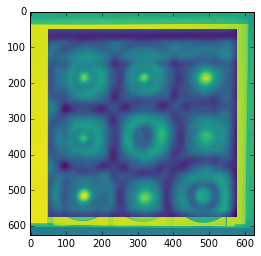

In [84]:
plt.imshow(img_out, cmap='viridis');

Seems to work.

## Edge detection
A big part of computer vision requires the dectection of objects within images.  To do this the edges of the objects need to be detected!  This is mainly done by the calculation of derivatives.

#### Sobel operator

This uses the matrix [[-1 0 1], [-2 0 2], [-1 0 1]] for the x-direction and [[1 2 1], [0 0 0], [-1 -2 -1]] for the y-direction.  Implementing this on my image gives us:

In [87]:
img_out_x = np.zeros(img_in_grey.shape)
img_out_y = np.zeros(img_in_grey.shape)

s_x = np.array([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]]) * 1./8.
s_y = np.array([[1., 2., 1.], [0., 0., 0.], [-1., -2., -1.]]) * 1./8.
x, y = img_in_grey.shape
hs = 1
for x_i in range(hs, x-hs):
    for y_i in range(hs, y-hs):
        img_out_x[x_i, y_i] = np.sum(s_x * img_in_grey[x_i-hs:x_i+hs+1, y_i-hs:y_i+hs+1])
        img_out_y[x_i, y_i] = np.sum(s_y * img_in_grey[x_i-hs:x_i+hs+1, y_i-hs:y_i+hs+1])

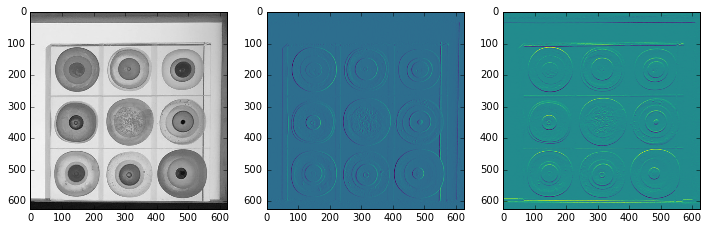

In [88]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))
ax[0].imshow(img_in_grey, cmap='gray')
ax[1].imshow(img_out_x, cmap='viridis')
ax[2].imshow(img_out_y, cmap='viridis')

This is quite a cool technique.  A more complex method for when images are noisy is to use a filter to smooth and then take the deriviative, or alternatively (and equivalently) use the derivative of the smoothing operator.  If the operator is a gaussian as above then:

In [93]:
filt_x = np.zeros(filt.shape)
filt_y = np.zeros(filt.shape)

s_x = np.array([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]]) * 1./8.
s_y = np.array([[1., 2., 1.], [0., 0., 0.], [-1., -2., -1.]]) * 1./8.
x, y = filt.shape
hs = 1
for x_i in range(hs, x-hs):
    for y_i in range(hs, y-hs):
        filt_x[x_i, y_i] = np.sum(s_x * filt[x_i-hs:x_i+hs+1, y_i-hs:y_i+hs+1])
        filt_y[x_i, y_i] = np.sum(s_y * filt[x_i-hs:x_i+hs+1, y_i-hs:y_i+hs+1])

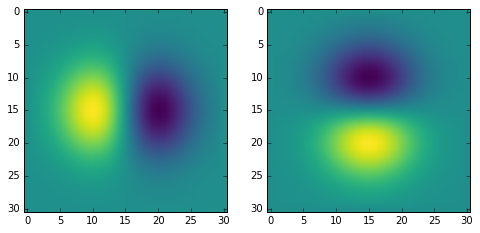

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(8,5))
ax[0].imshow(filt_x, cmap='viridis')
ax[1].imshow(filt_y, cmap='viridis')

In [98]:
img_out_x = np.zeros(img_in_grey.shape)
img_out_y = np.zeros(img_in_grey.shape)

s_x = filt_x
s_y = filt_y
x, y = img_in_grey.shape
hs = 15
for x_i in range(hs, x-hs):
    for y_i in range(hs, y-hs):
        img_out_x[x_i, y_i] = np.sum(s_x * img_in_grey[x_i-hs:x_i+hs+1, y_i-hs:y_i+hs+1])
        img_out_y[x_i, y_i] = np.sum(s_y * img_in_grey[x_i-hs:x_i+hs+1, y_i-hs:y_i+hs+1])

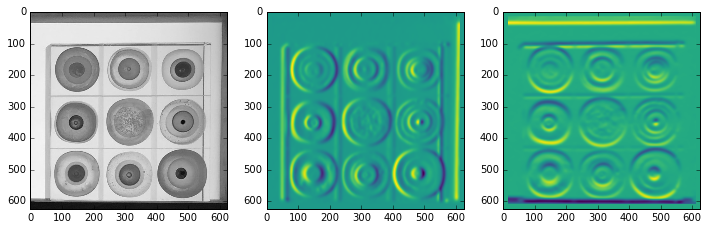

In [99]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))
ax[0].imshow(img_in_grey, cmap='gray')
ax[1].imshow(img_out_x, cmap='viridis')
ax[2].imshow(img_out_y, cmap='viridis')

Works pretty well.

I think this is the technique used in the Canny edge detection algorithm.  I'm not going to write my own implementation of that, but basically the steps are:
    1. Filter image with the derivative of a gaussian
    2. Find the magnitude and orientation of the gradiant
    3. Use "non-maximum suppression" - this effectively reduces the width of edges down to pixels by looking for local maximum points.
    4. Link and threshold the edge points.

Applying this to my image using sckit-image, and varying the sigma (smoothing) value:

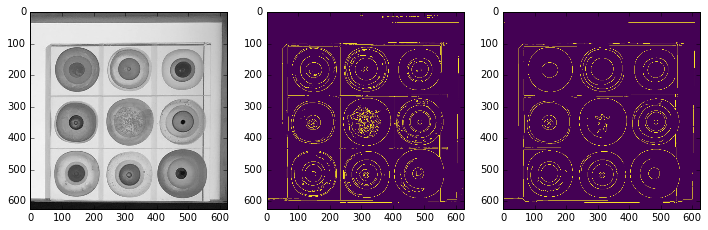

In [107]:
from skimage import feature

edges1 = feature.canny(img_in_grey)
edges2 = feature.canny(img_in_grey, sigma=2)

fig, ax = plt.subplots(1, 3, figsize=(12,5))
ax[0].imshow(img_in_grey, cmap='gray')
ax[1].imshow(edges1, cmap='viridis')
ax[2].imshow(edges2, cmap='viridis')

When zooming in, you can see that the edge has been accurately detected!

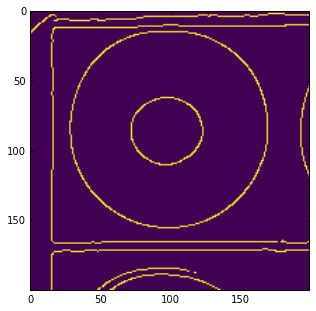

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(5,5)) 
ax.imshow(edges2[100:300, 50:250], cmap='viridis')

## Hough Transforms
Next up is Hough line detection using the transform method.